### Elective Lab 1/3: Lab 5b
#### Katie Robinson

Add foxes that prey on rabbits to Daisy World. By changing the various degrees of freedom in this problem, look for “predator-prey” oscillations, in which the fox and rabbit populations go through periodic highs and lows. Hand-in a discussion and plots describing and showing the most interesting oscillations/longest non-trivial steady state you can find.

In the first half of lab 5, I modified the daisy world model to include an evolving population of rabbits that feed on the daises. The
rabbit birth rate will be proportional to the area covered by the daisies while, conversely, the daisy *death rate* will be proportional to the rabbit population. To recap the changes I made in this part of the lab:

The rabbit concentration changes over time according to $$\frac{dR}{dt} = A_R(\beta_R x-\chi_R),$$ where $\beta_R$ is the bunny growth rate and x is the fractional area of bare ground, $$x = 1 - A_w - A_b - A_R,$$ 

where $A_w$, $A_b$, and $A_R$ are the fractions of the total planetary area covered by white daises, black daises, and rabbits, respectively, and $\chi_R$ is the bunny death rate. These variables ($\beta_R$, $\chi_R$) were also added to the initvars file under uservars.

Additionally, I added the rabbit population into the daisy equations, so that the daisy death rate is proportional to the population of rabbits. The more rabbits there are, the more quickly the population of daisies will decline. The new daisy equations are $$\frac{dA_b}{dt} = A_b(\beta_b x-\chi A_R),$$ $$\frac{dA_w}{dt} = A_w(\beta_w x-\chi A_R).$$

The next step is to add foxes that prey on rabbits but leave daises alone. The fox birth rate will be proportional to the population of rabbits (ie. the planetary area covered by rabbits) and the rabbit death rate will be proportional to the population of foxes. 

The fox concentration changes over time according to $$\frac{dF}{dt} = A_F(\beta_R x-\chi_R),$$ where $\beta_R$ is the bunny growth rate and x is the fractional area of bare ground, $$x = 1 - A_w - A_b - A_R,$$ 


In [24]:
# functions for problem initial
import context
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# New integrator class that includes rabbits

class Rabbits(Integrator):
    def set_yinit(self,new_blackconc,new_whiteconc,bunny_conc):
        #
        # read in 'albedo_white chi S0 L albedo_black R albedo_ground'
        #
        self.config["initvars"]["blackconc"] = new_blackconc
        self.config["initvars"]["whiteconc"] = new_whiteconc
        self.config["initvars"]["bunnyconc"] = bunny_conc
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array([self.initvars.whiteconc, self.initvars.blackconc,self.initvars.bunnyconc])
        self.nvars = len(self.yinit)
        return self.yinit

    def __init__(self, coeff_file_name,new_blackconc,new_whiteconc,bunny_conc):
        super().__init__(coeff_file_name)
        self.set_yinit(new_blackconc,new_whiteconc,bunny_conc)
        #self.set_yinit(new_whiteconc)
        self.blackconc = new_blackconc
        self.whiteconc = new_whiteconc
        self.bunnyconc = bunny_conc

    def find_temp(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions
            
            input:  yvals -- array of dimension [2] with the white [0] and black [1]
                    daisy fractiion
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.L * user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        return (temp_w, temp_b, temp_e)

    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           y[2]=fraction of bunnies
           no feedback between daisies and
           albedo_p (set to ground albedo)
        """
        
        temp_w, temp_b, temp_e = self.find_temp(y)

        if (temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if (temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
        user = self.uservars
        bare = 1.0 - y[0] - y[1]
        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty_like(y)
        f[2] = y[2] * (user.beta_r * (1-bare) - user.chiR)
        f[0] = y[0] * (beta_w * bare - user.chi - f[2])
        f[1] = y[1] * (beta_b * bare - user.chi - f[2])
        
        return f

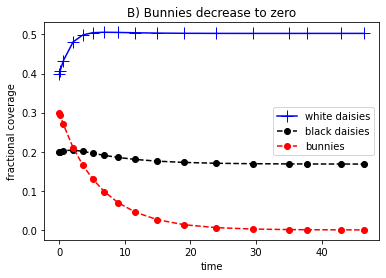

In [25]:
Predators = Rabbits('adapt.yaml',0.2,0.4,0.3)
timeVals, yVals, errorList = Predators.timeloop5Err()

yvals = pd.DataFrame.from_records(yVals, columns=['white', 'black','bunnies'])
#yVals

thefig, theAx = plt.subplots(1, 1)

points, = theAx.plot(timeVals, yvals['white'], '-b+', label='white daisies')
points.set_markersize(12)
theLine1, = theAx.plot(timeVals, yvals['black'], '--ko', label='black daisies')
theLine2, = theAx.plot(timeVals, yvals['bunnies'], '--ro', label='bunnies')
theAx.set_title('B) Bunnies decrease to zero')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='best')